## Section 1: Estimating model parameters
In this section we will discuss how Bayesians think about data, and how we can estimate model parameters using a technique called MCMC.

In [1]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### How do Bayesians think about data?
When I started to learn how to apply Bayesian methods, I found it very useful to understand how Bayesians think about data. Imagine the following scenario:
> A curious boy watches the number of cars that pass by his house every day. He diligently notes down the total count of cars that pass per day. Over the past week, his notebook contains the following counts: 12, 33, 20, 29, 20, 30, 18

From a Bayesian's perspective, this data is generated by a random process. However, now that the data is observed, it is fixed and does not change. This random process has some model parameters that are fixed. However, the Bayesian uses probability distributions to represent his/her uncertainty in these parameters.

Because the boy is measuring counts (non-negative integers), it is common practice to use a Poisson distribution to model the data (eg. the random process). A Poisson distribution takes a single parameter $\mu$ which describes both the mean and variance of the data. You can see 3 Poisson distributions below with different values of $\mu$.

$$p(x \ | \ \mu) = \frac{e^{-\mu}\mu^{x}} {x!} \mbox{    for     } 
x = 0, 1, 2, \cdots$$

$$\lambda = E(x) = Var(\mu)$$

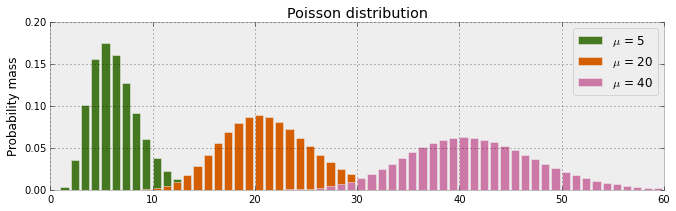

In [2]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5, 20, 40]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[4])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[5])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

In the previous section we imported my hangout chat dataset. I'm particularly interested in the time it takes me to respond to messages (`response_time`). Given that `response_time` is count data, we can model it as a Poisson distribution and estimate its parameter $\mu$. We will explore both a frequentist and Bayesian method of estimating this parameter.

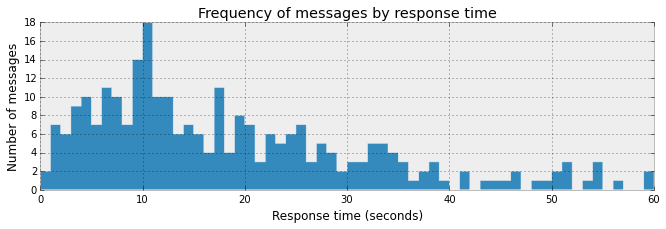

In [3]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values, 
             range=[0, 60], bins=60, histtype='stepfilled')

### Frequentists method of estimating $\mu$
Before we jump into Bayesian techniques, lets first look at a frequentist method of estimating the parameters of a Poisson distribution. We will use an optimization technique that aims to maximize the likelihood of a function.

The below function `poisson_logprob()` returns the overall likelihood of the observed data given a Poisson model and parameter value. We use the method `opt.minimize_scalar` to find the value of $\mu$ that is most credible (maximizes the log likelihood) given the data observed. Under the hood, this optimization technique is intelligently iterating through possible values of `mu` until it finds a value with the highest likelihood.

In [4]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 18.0413533867
CPU times: user 63 µs, sys: 1e+03 ns, total: 64 µs
Wall time: 67.9 µs


So, the estimate of the value of $\mu$ is 18.0413533867. The optimization technique doesn't provide any measure of uncertainty - it just returns a point value. And it does so very efficiently...

The below plot illustrates the function that we are optimizing. At each value of $\mu$, the plot shows the log probability at $\mu$ given the data and the model. The optimizer works in a hill climbing fashion - starting at a random point on the curve and incrementally climbing until it cannot get to a higher point.

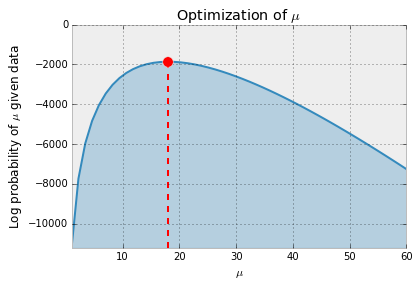

In [5]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])
fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)
_ = plt.title('Optimization of $\mu$')
_ = plt.xlabel('$\mu$')
_ = plt.ylabel('Log probability of $\mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=60)

The above optimization has estimated the parameter ($\mu$) of a Poisson model to be 18. We know for any Poisson distribution, the parameter $\mu$ represents both its mean and variance. The below plot illustrates this distribution.

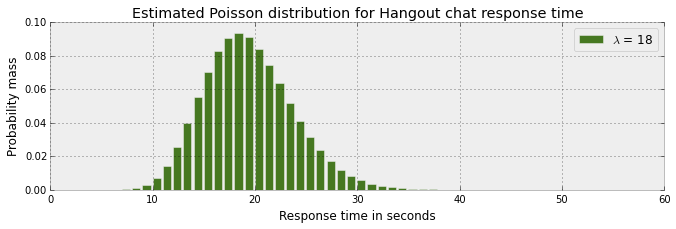

In [6]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$\lambda$ = %s' % mu])

The above Poisson model and estimated value of $\mu$ suggest that there is minimal chance of an observation less than 10 or greater than 30. The vast majority of the probability mass is between 10 and 30. However, we know this is not reflected in the data that we observed - which has observed values between 0 and 60.

### Bayesian method of estimating $\mu$

If you've encountered Bayes' theorem before, the below formula will look familiar. This framework never resonated with me until I read John K. Kruschke's book "Doing Bayesian Data Analysis" and saw the below formula through the lens of his beautifully simple Bayesian graphical models.
 
$$\overbrace{p(\mu \ |\ Data)}^{\text{posterior}} = \dfrac{\overbrace{p(Data \ | \ \mu)}^{\text{likelihood}} \cdot \overbrace{p(\mu)}^{\text{prior}}}{\underbrace{p(Data)}_{\text{marginal likelihood}}}$$

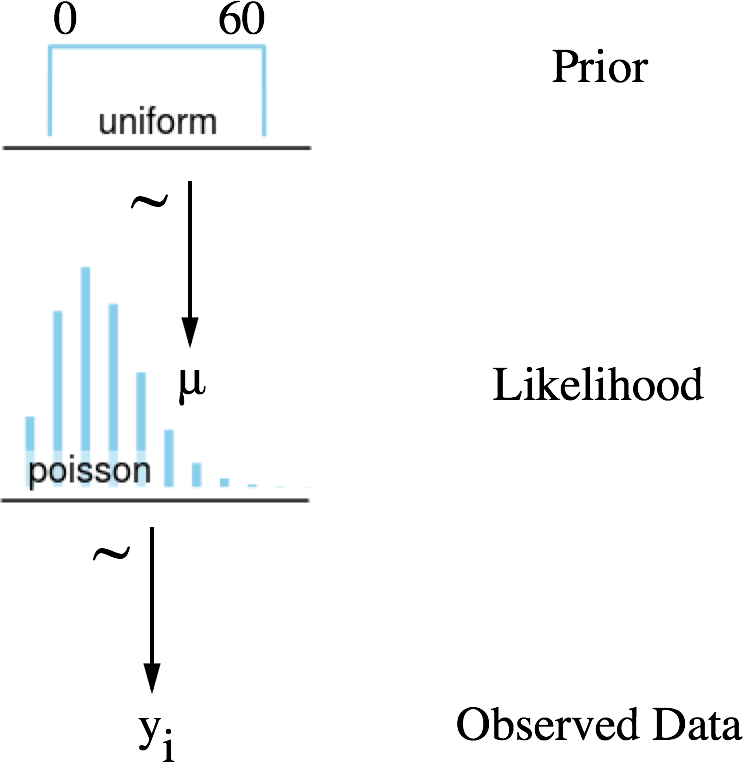

In [7]:
Image('graphics/Poisson-dag.png', width=320)

The above schema can be interpreted as follows (from the bottom up):
- We observe counts of data (y) for each conversation i (Observed Data)
- This data was generated by a random process which we believe can be represented as a Poisson distribution (Likelihood)
- This Poisson distribution has a single parameter $\mu$ which we know is between 0 and 60 (Prior)
  - We will model $\mu$ as a uniform distribution because we do not have an opinion as to where within this range to expect it

### The magical mechanics of MCMC
The process of Markov Chain Monte Carlo (MCMC) is nicely illustrated in the below animation. The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values. 

$$\overbrace{p(\mu \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \mu)}^{likelihood} \cdot \overbrace{p(\mu)}^{prior}$$

This calculation acts as a guiding light for the MCMC sampler. As it draws values from the paramater priors, it computes the likelihood of these paramters given the data - and will try to guide the sampler towards areas of higher probability.

In a conceptually similar manner to the frequentist optimization technique discussed above, the MCMC sampler wanders towards areas of highest likelihood. However, the Bayesian method is not concerned with findings the absolute maximum values - but rather to traverse and collect samples around the area of highest probability. All of the samples collected are considered to be a credible parameter.

In [8]:
Image(url='graphics/mcmc-animate.gif')

In [9]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=60)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 48.3 sec

The above code has just gathered 200,000 credible samples of $\mu$ by traversing over the areas of high likelihood of the posterior distribution of $\mu$. The below plot (left) shows the distribution of values collected for $\mu$. The mean of this distribution is almost identical to the frequentist estimate (red line). However, we also get a measure of uncertainty and can see that there are credible values of $\mu$ between 17 and 19. This measure of uncertainty is incredibly valuable as we will see later.

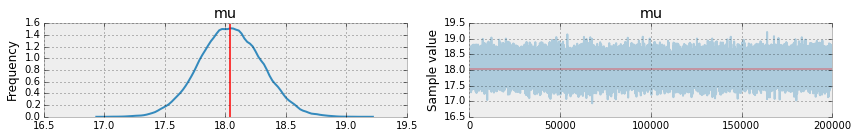

In [10]:
_ = pm.traceplot(trace, varnames=['mu'], lines={'mu': freq_results['x']})

### Discarding early samples (burnin)
You may have wondered what the purpose of `pm.find_MAP()` is in the above MCMC code. MAP stands for maximum a posteriori estimation. It helps the MCMC sampler find a good place from which to start sampling. Ideally this will start the model off in an area of high likelihood - but sometimes that doesn't happen. As a result, the samples collected early in the trace (burnin samples) are often discarded.

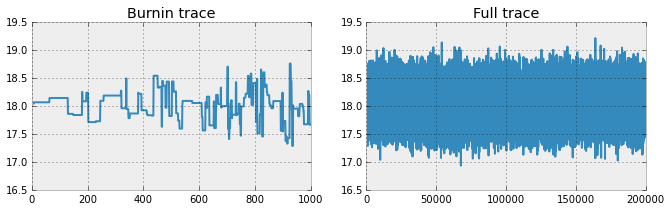

In [11]:
fig = plt.figure(figsize=(11,3))
plt.subplot(121)
_ = plt.title('Burnin trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu')[:1000])
fig = plt.subplot(122)
_ = plt.title('Full trace')
_ = plt.ylim(ymin=16.5, ymax=19.5)
_ = plt.plot(trace.get_values('mu'))

### Model convergence
#### Trace
Just because the above model estimated a value for $\mu$, doesn't mean the model estimated a good value given the data. There are some recommended checks that you can make. Firstly, look at the trace output. You should see the trace jumping around and generally looking like a hairy caterpillar. If you see the trace snake up and down or appear to be stuck in any one location - it is a sign that you have convergence issues and the estimations from the MCMC sampler cannot be trusted.

#### Autocorrelation plot
The second test you can perform is the autocorrelation test (see below plot). It is a measure of correlation between successive samples in the MCMC sampling chain. When samples have low correlation with each other, they are adding more "information" to the estimate of your parameter value than samples that are highly correlated.

Visually, you are looking for an autocorrelation plot that tapers off to zero relatively quickly and then oscilates above and below zero correlation. If your autocorrelation plot does not taper off - it is generally a sign of poor mixing and you should revisit your model selection (eg. likelihood) and sampling methods (eg. Metropolis).

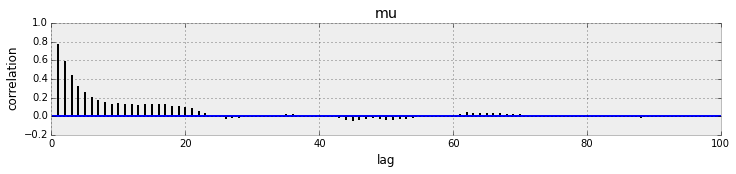

In [12]:
_ = pm.autocorrplot(trace[:2000], varnames=['mu'])

#### [>> Go to the Next Section](http://nbviewer.ipython.org/github/markdregan/Bayesian-Modelling-in-Python/blob/master/Section%202.%20Model%20checking.ipynb)

### References
- [MCMC animation by Maxwell Joeseph](http://blog.revolutionanalytics.com/2013/09/an-animated-peek-into-the-workings-of-Bayesian-statistics.html)

In [13]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()